In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 

# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)

# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

## Grid search $\alpha$ with interactions

In [3]:
N = 10
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.MetropolisHastings(wf)

# Config
nsamples = 20000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            dt=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=10000,
                            tune_interval=250,
                            tol_tune=1e-7,
                            optimize=False
                           )
    results.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Final dt val: 0.011533007812500003, with accept rate: 0.424
Tune done
Sampling energy
Warm done
Final dt val: 0.006305672021484378, with accept rate: 0.476
Tune done
Sampling energy
Warm done
Final dt val: 0.004540083855468752, with accept rate: 0.44
Tune done
Sampling energy
Warm done
Final dt val: 0.003405062891601563, with accept rate: 0.424
Tune done
Sampling energy
Warm done
Final dt val: 0.005339355468750001, with accept rate: 0.428
Tune done
Sampling energy
Warm done
Final dt val: 0.002627363342285157, with accept rate: 0.428
Tune done
Sampling energy
Warm done
Final dt val: 0.002432743835449219, with accept rate: 0.448
Tune done
Sampling energy
Warm done
Final dt val: 0.0018917016064453128, with accept rate: 0.48
Tune done
Sampling energy
Warm done
Final dt val: 0.002162438964843751, with accept rate: 0.416
Tune done
Sampling energy
Warm done
Final dt val: 0.0015764180053710942, with accept rate: 0.428
Tune done
Sampling energy
Warm done
Final dt val: 0.00126113440429

In [4]:
df_N10 = pd.concat(results, ignore_index=True)
df_N10

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,10,3,0.10,4.966632,0.036371,0.012325
1,10,3,0.15,5.829536,0.023214,0.013517
2,10,3,0.20,7.098859,0.016165,0.013198
3,10,3,0.25,8.361501,0.010067,0.013653
4,10,3,0.30,9.720010,0.007363,0.009330
5,10,3,0.35,11.119801,0.005220,0.013582
6,10,3,0.40,12.548059,0.003292,0.012985
7,10,3,0.45,13.980848,0.001540,0.014235
8,10,3,0.50,15.427574,0.000539,0.011828
9,10,3,0.55,16.885660,0.001610,0.014225


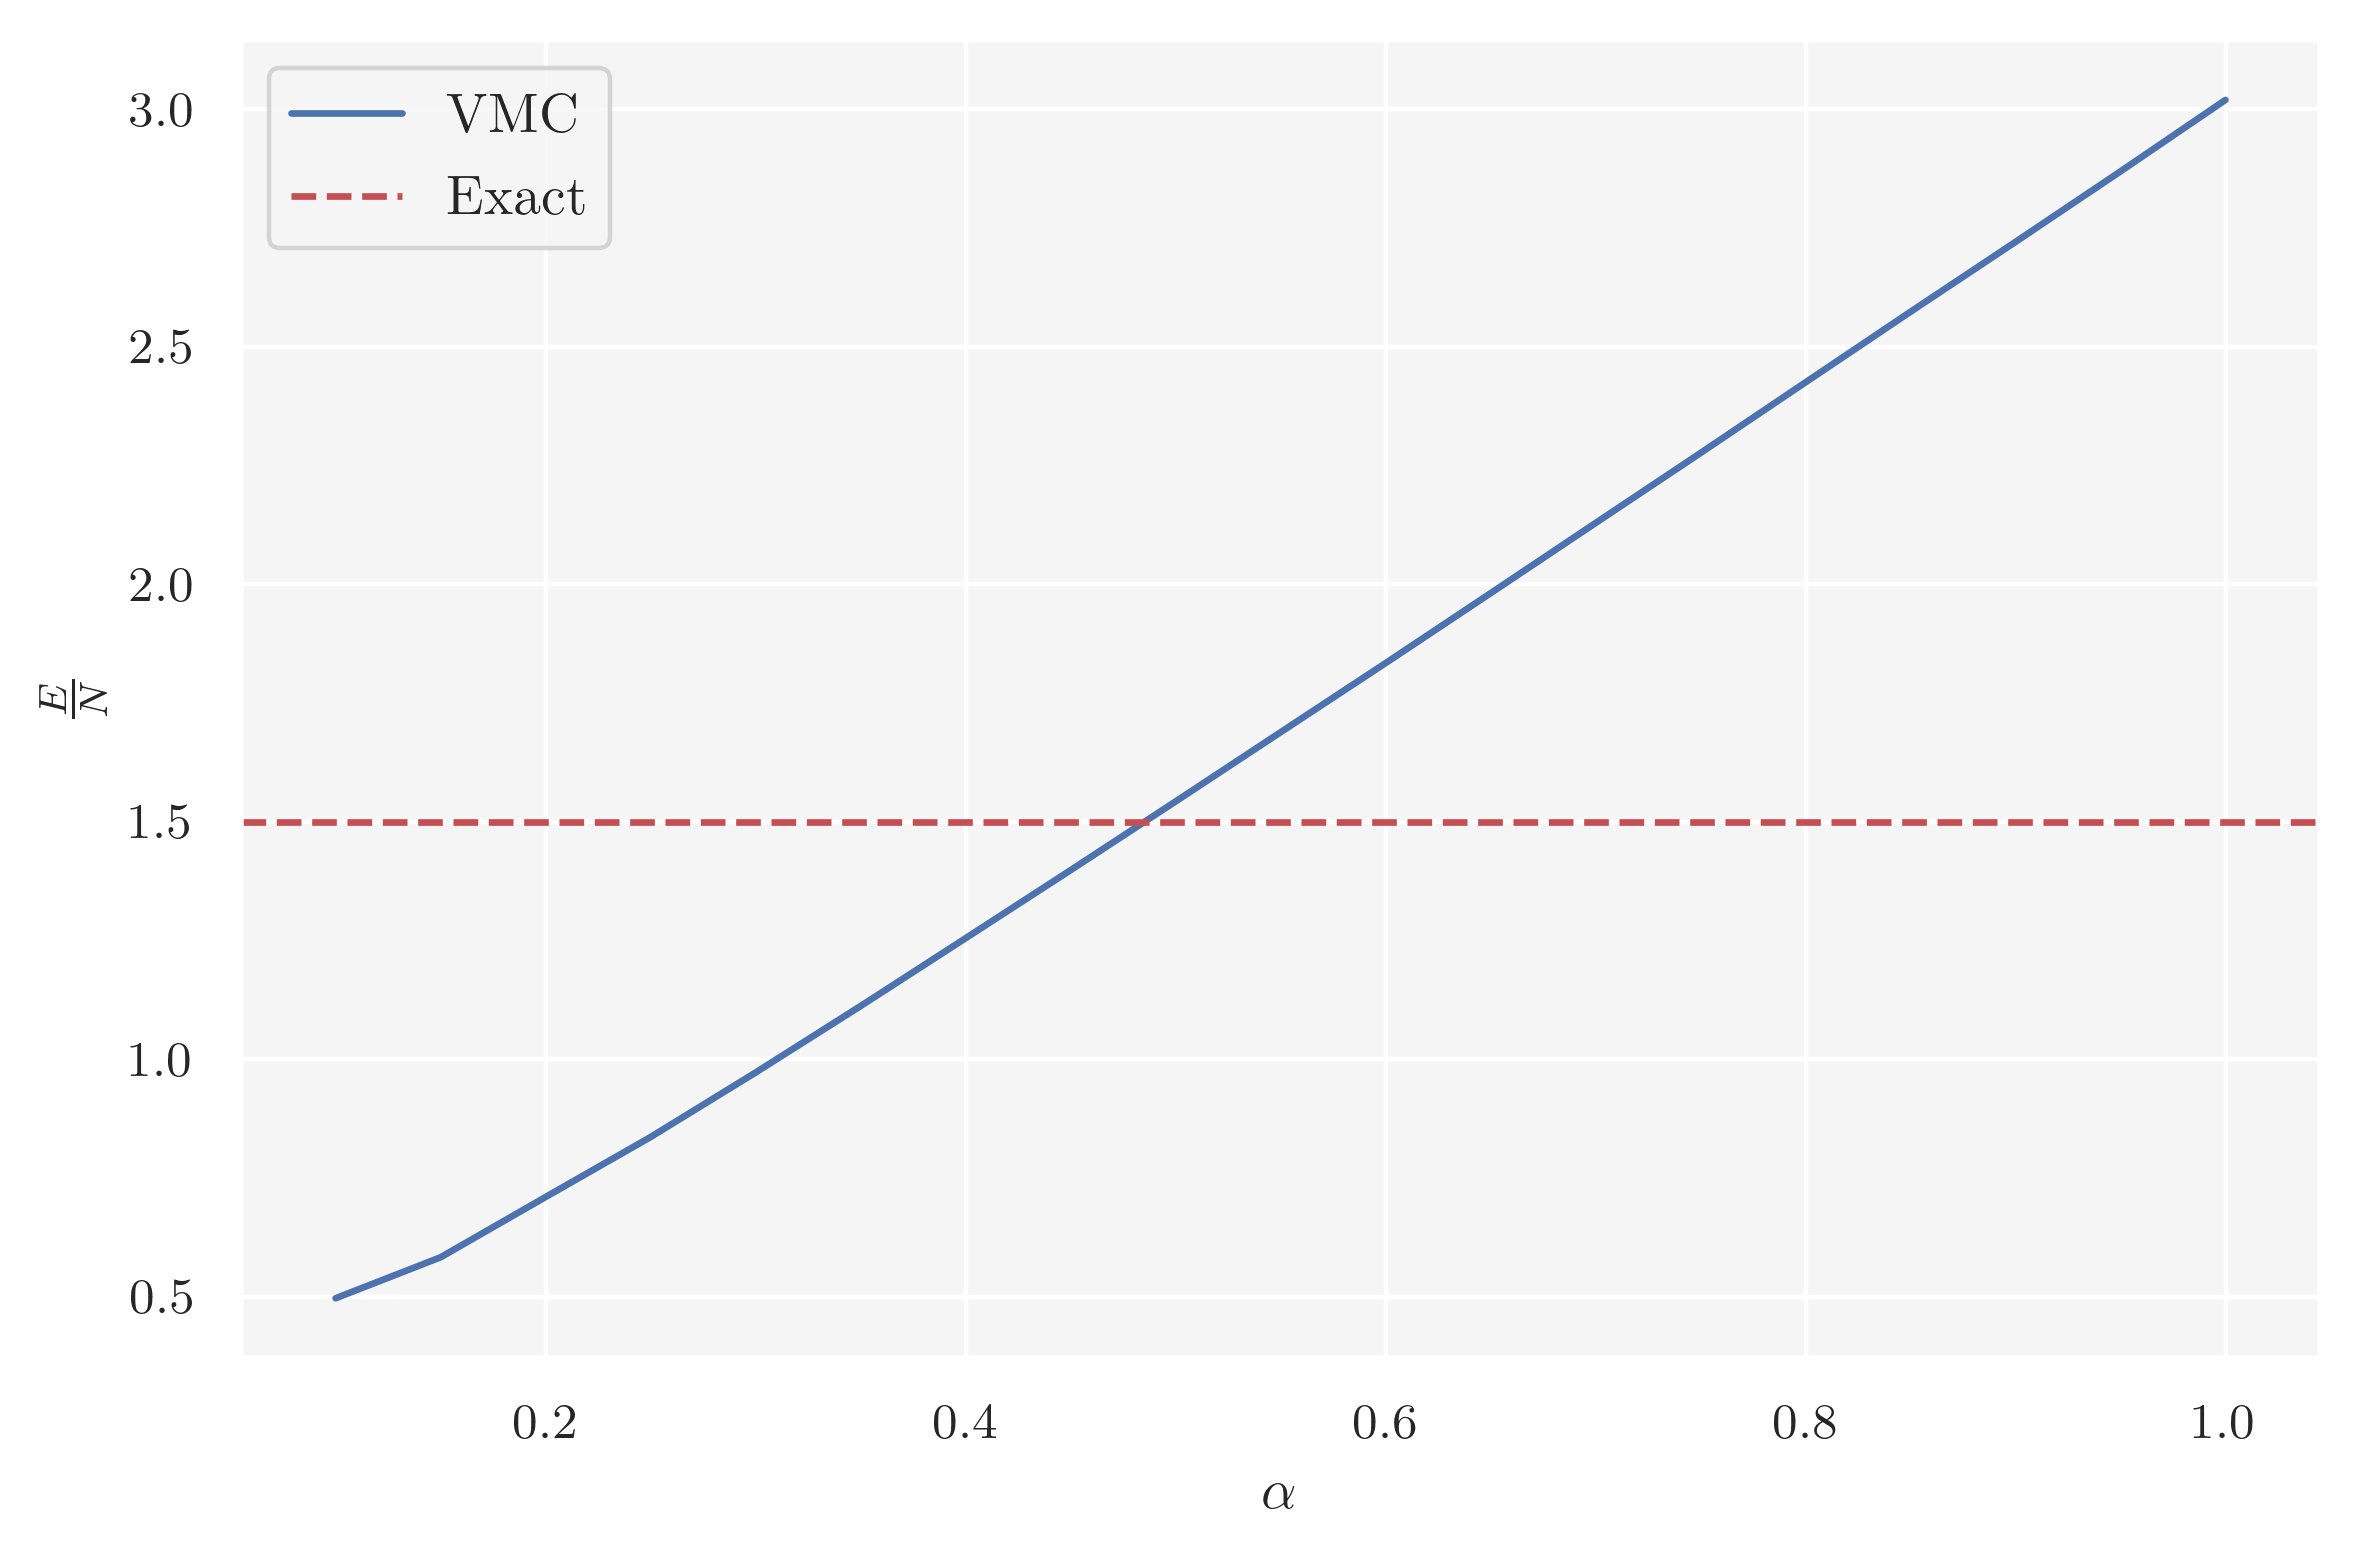

In [5]:
mod_df_10 = df_N10
mod_df_10["energy"] = mod_df_10["energy"]/10.0
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_10, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(NI_exact_energy_10/10.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_10.pdf"), bbox_inches='tight')

In [3]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_50 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 10000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N50 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=10000,
                            tune_interval=500,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N50.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Final acceptance rate 0.376 and scale 0.14641000000000004
Tune done
Sampling energy
Warm done
Final acceptance rate 0.254 and scale 0.1948717100000001
Tune done
Sampling energy
Warm done
Final acceptance rate 0.214 and scale 0.23914845000000007
Tune done
Sampling energy
Warm done
Final acceptance rate 0.282 and scale 0.25
Tune done
Sampling energy
Warm done
Final acceptance rate 0.41 and scale 0.11000000000000001
Tune done
Sampling energy
Warm done
Final acceptance rate 0.382 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.202 and scale 0.2025
Tune done
Sampling energy
Warm done
Final acceptance rate 0.292 and scale 0.14762250000000005
Tune done
Sampling energy
Warm done
Final acceptance rate 0.302 and scale 0.16402500000000003
Tune done
Sampling energy
Warm done
Final acceptance rate 0.436 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.482 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.476 and sc

In [5]:
df_N50 = pd.concat(results_N50, ignore_index=True)
df_N50

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,50,3,0.10,188.412011,20.629121,0.004341
1,50,3,0.15,124.789499,4.581704,0.002894
2,50,3,0.20,109.897948,1.876194,0.001457
3,50,3,0.25,94.374291,1.075347,0.001043
4,50,3,0.30,82.149797,1.800422,0.003912
5,50,3,0.35,80.773380,1.568127,0.003797
6,50,3,0.40,81.277049,0.283108,0.000889
7,50,3,0.45,79.978729,0.337644,0.001704
8,50,3,0.50,79.367537,0.037755,0.001149
9,50,3,0.55,81.418223,0.397925,0.003167


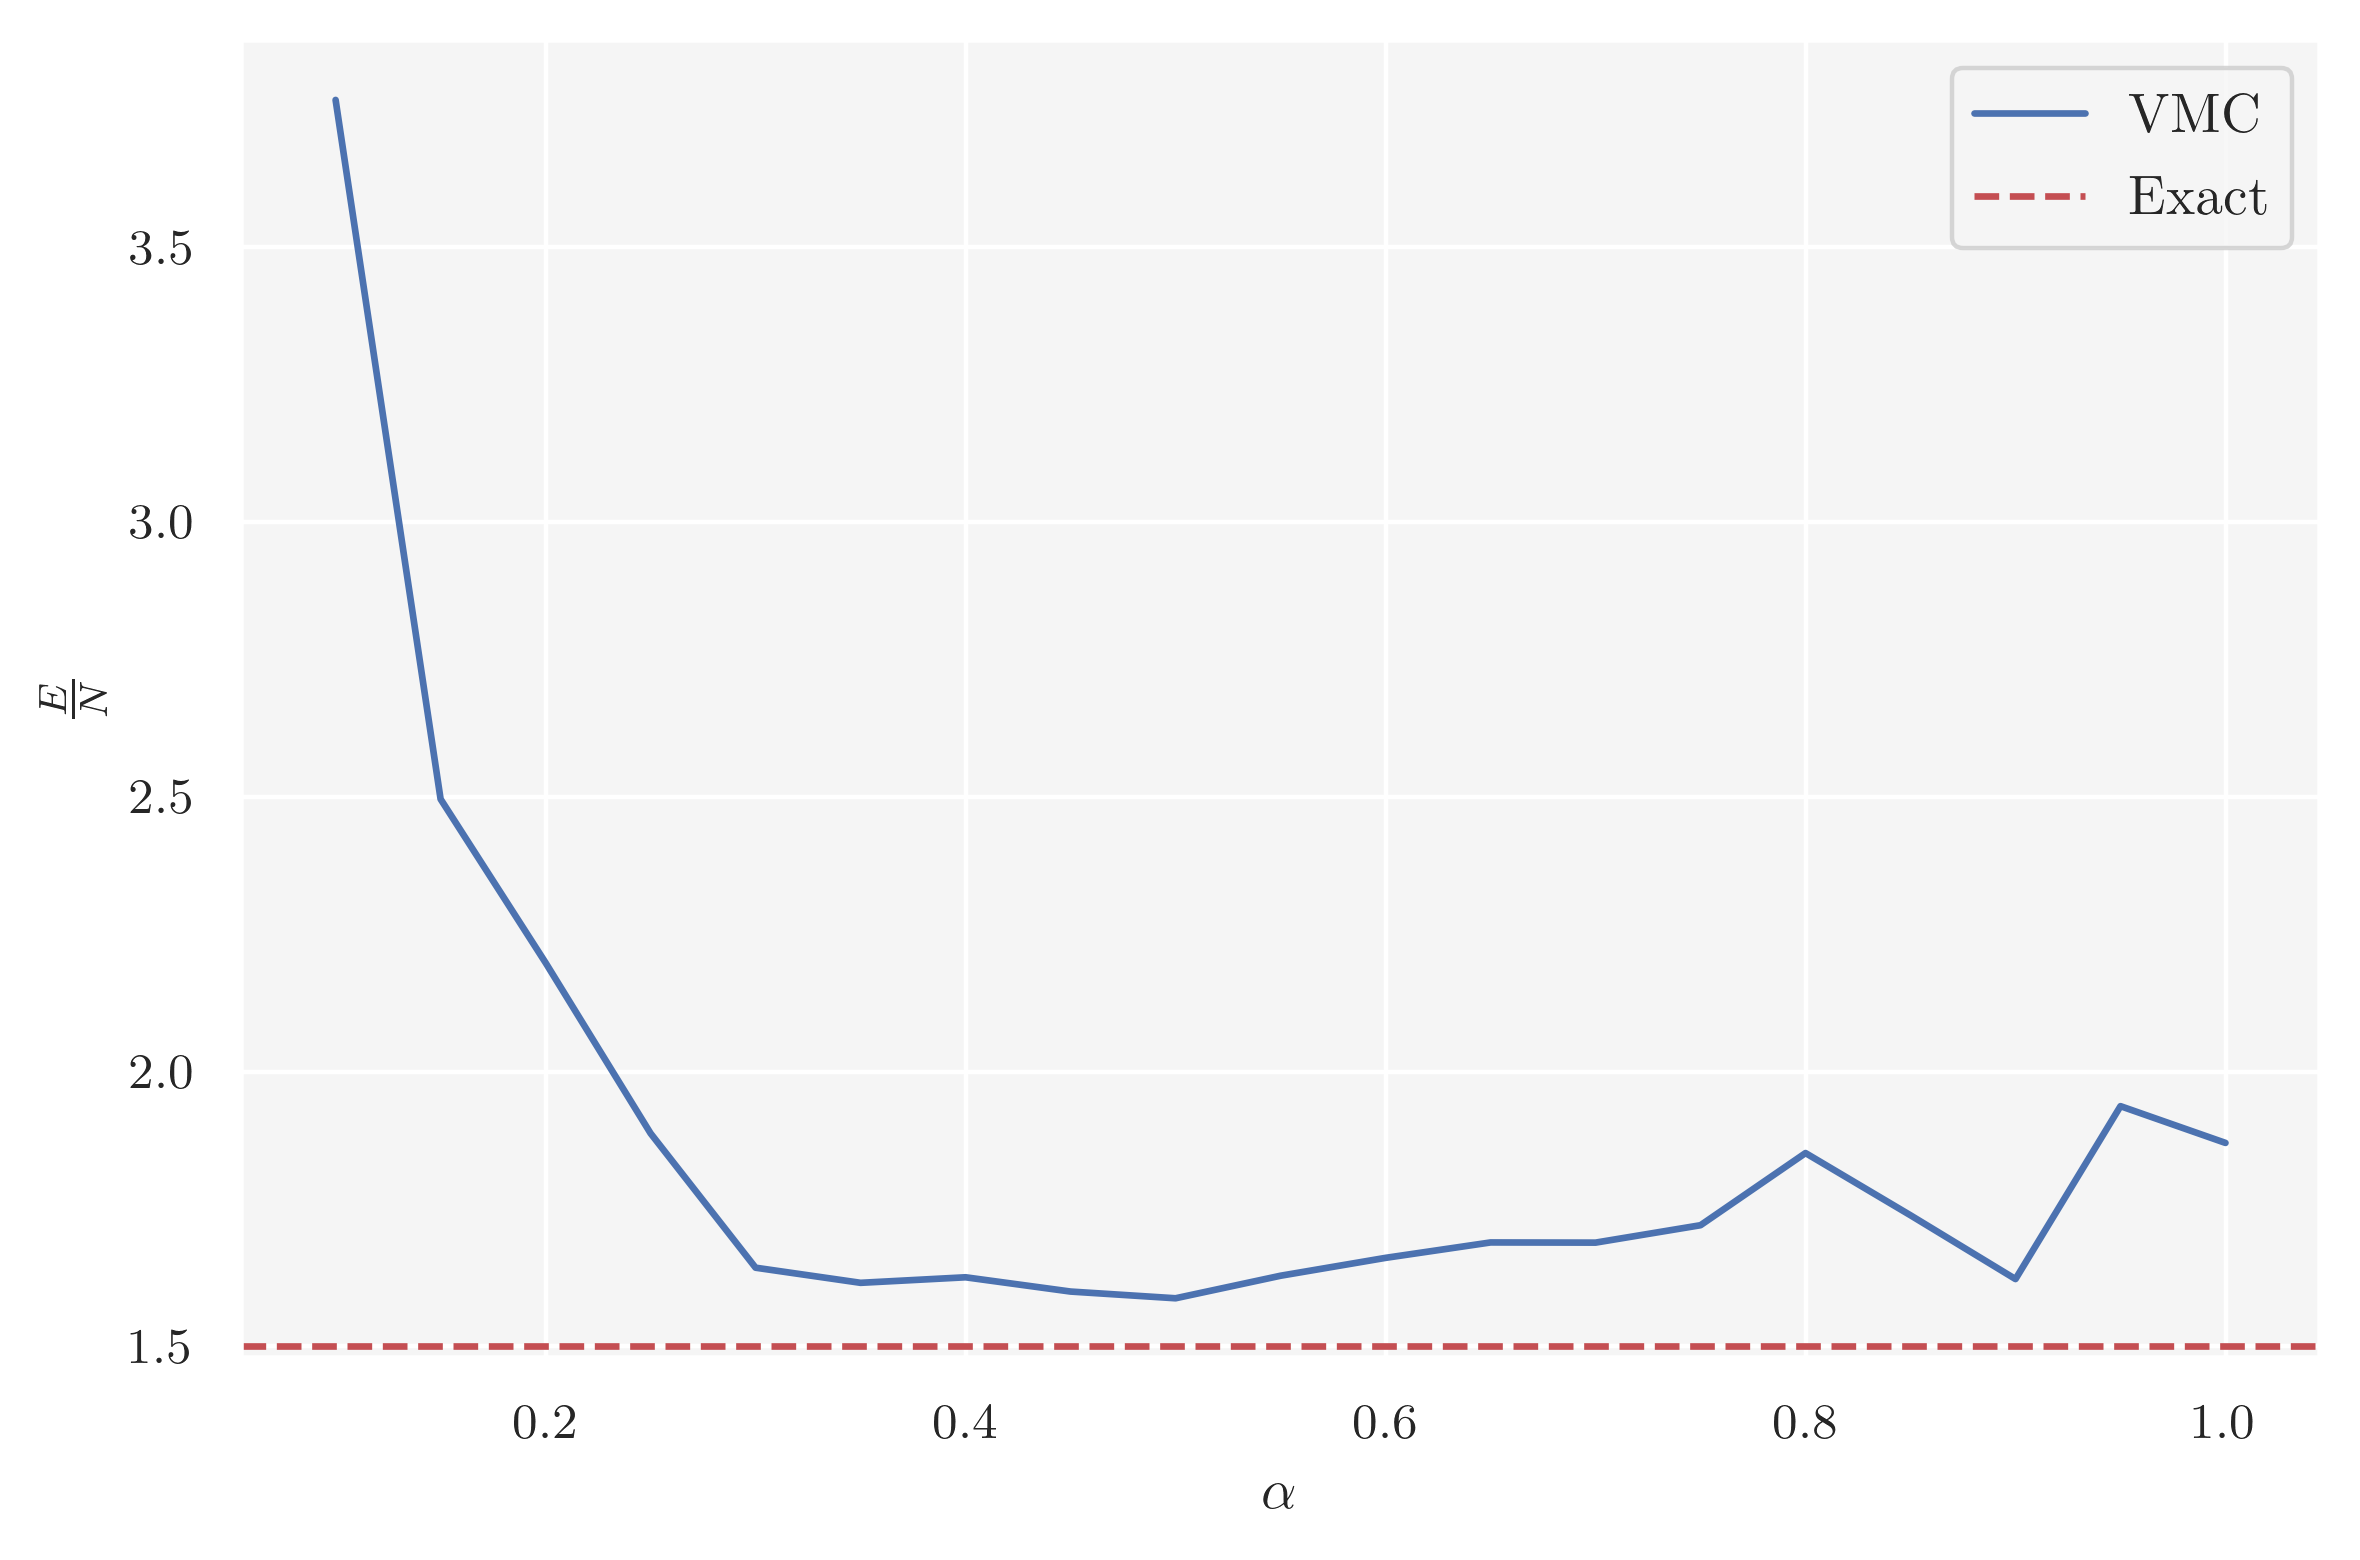

In [6]:
mod_df_50 = df_N50
mod_df_50["energy"] = mod_df_50["energy"]/50.0
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_50, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(NI_exact_energy_50/50.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_50.pdf"), bbox_inches='tight')

In [6]:
N = 100
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_100 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 10000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N100 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=5000,
                            tune_interval=250,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N100.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Final acceptance rate 0.428 and scale 0.09900000000000002
Tune done
Sampling energy
Warm done
Final acceptance rate 0.484 and scale 0.11000000000000001
Tune done
Sampling energy
Warm done
Final acceptance rate 0.436 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.296 and scale 0.13310000000000002
Tune done
Sampling energy
Warm done
Final acceptance rate 0.472 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.376 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.424 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.336 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.42 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.348 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.344 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.324 and scale 0.1
Tune done
Sampling energy
Warm done
Final a

In [7]:
df_N100 = pd.concat(results_N100, ignore_index=True)
df_N100

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,100,3,0.10,363.143766,28.814600,0.002264
1,100,3,0.15,260.080048,16.702470,0.001800
2,100,3,0.20,253.659955,26.169222,0.001665
3,100,3,0.25,227.862577,9.761735,0.000841
4,100,3,0.30,201.731549,6.071858,0.001349
5,100,3,0.35,181.507464,4.445929,0.001278
6,100,3,0.40,174.792385,3.677446,0.001219
7,100,3,0.45,171.121689,2.118338,0.001089
8,100,3,0.50,166.289000,0.357247,0.000846
9,100,3,0.55,164.315696,3.244491,0.000871


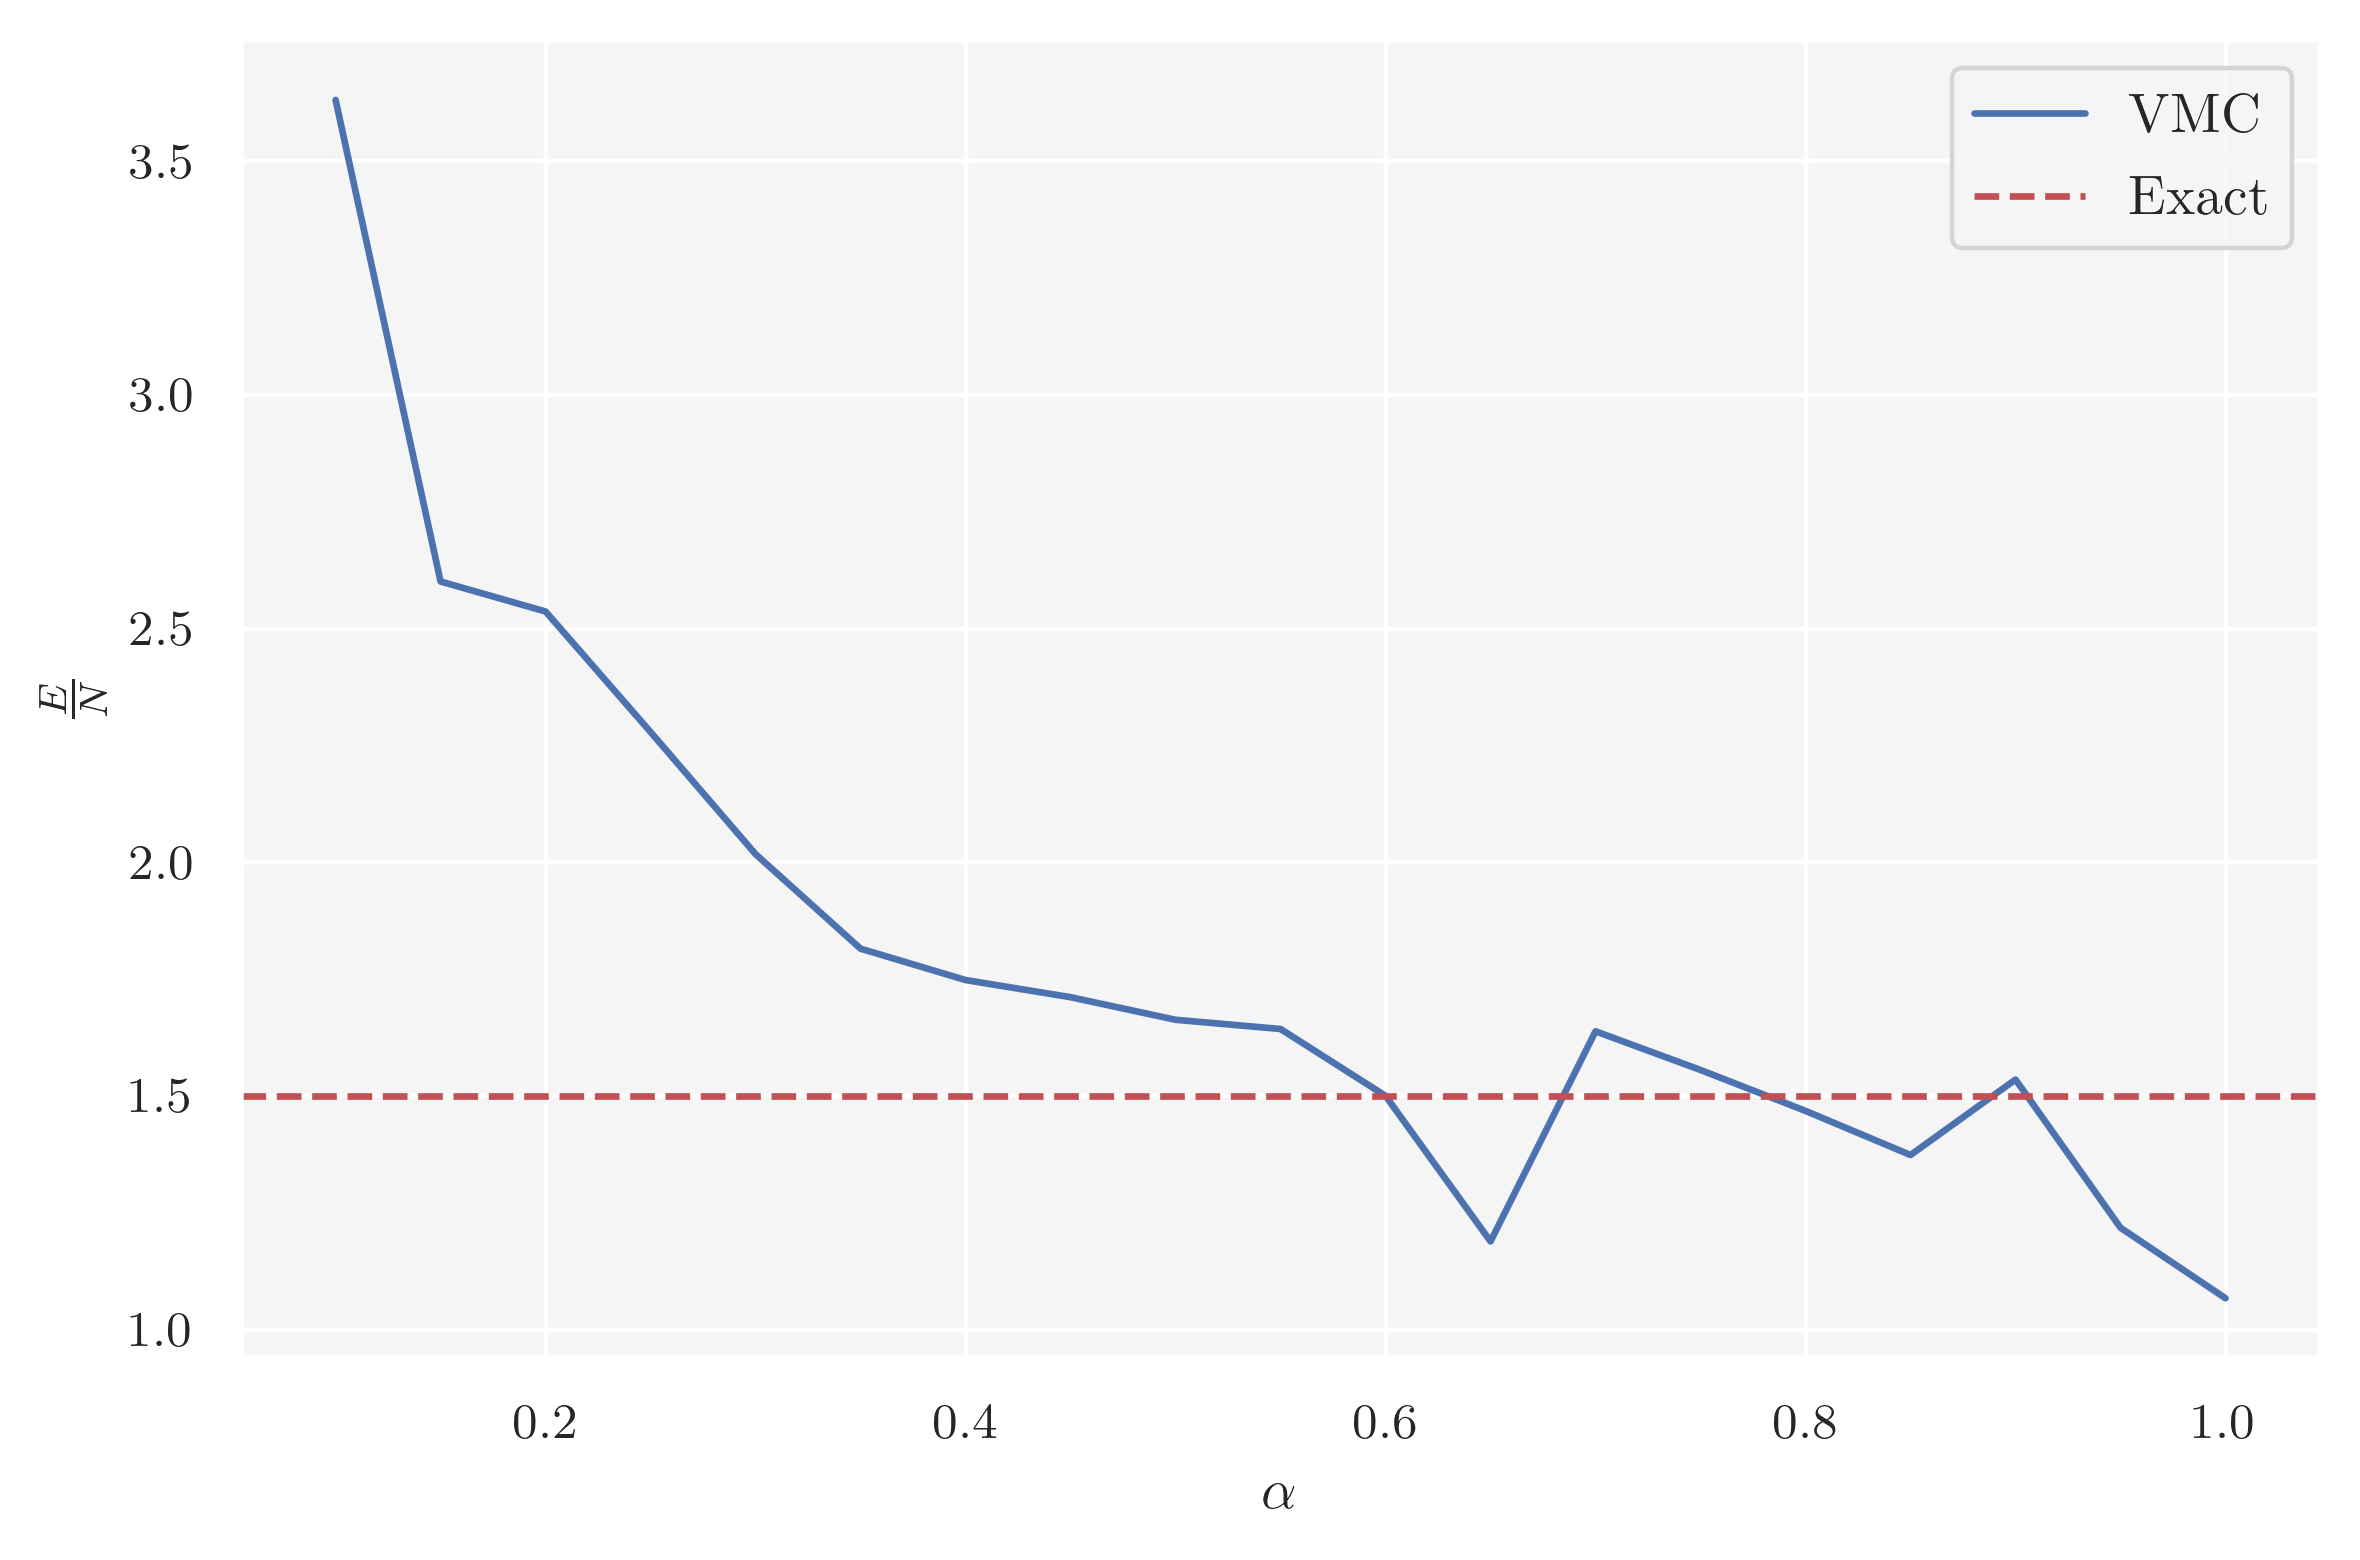

In [8]:
mod_df_100 = df_N100
mod_df_100["energy"] = mod_df_100["energy"]/100.0
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_100, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(NI_exact_energy_100/100.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_100.pdf"), bbox_inches='tight')

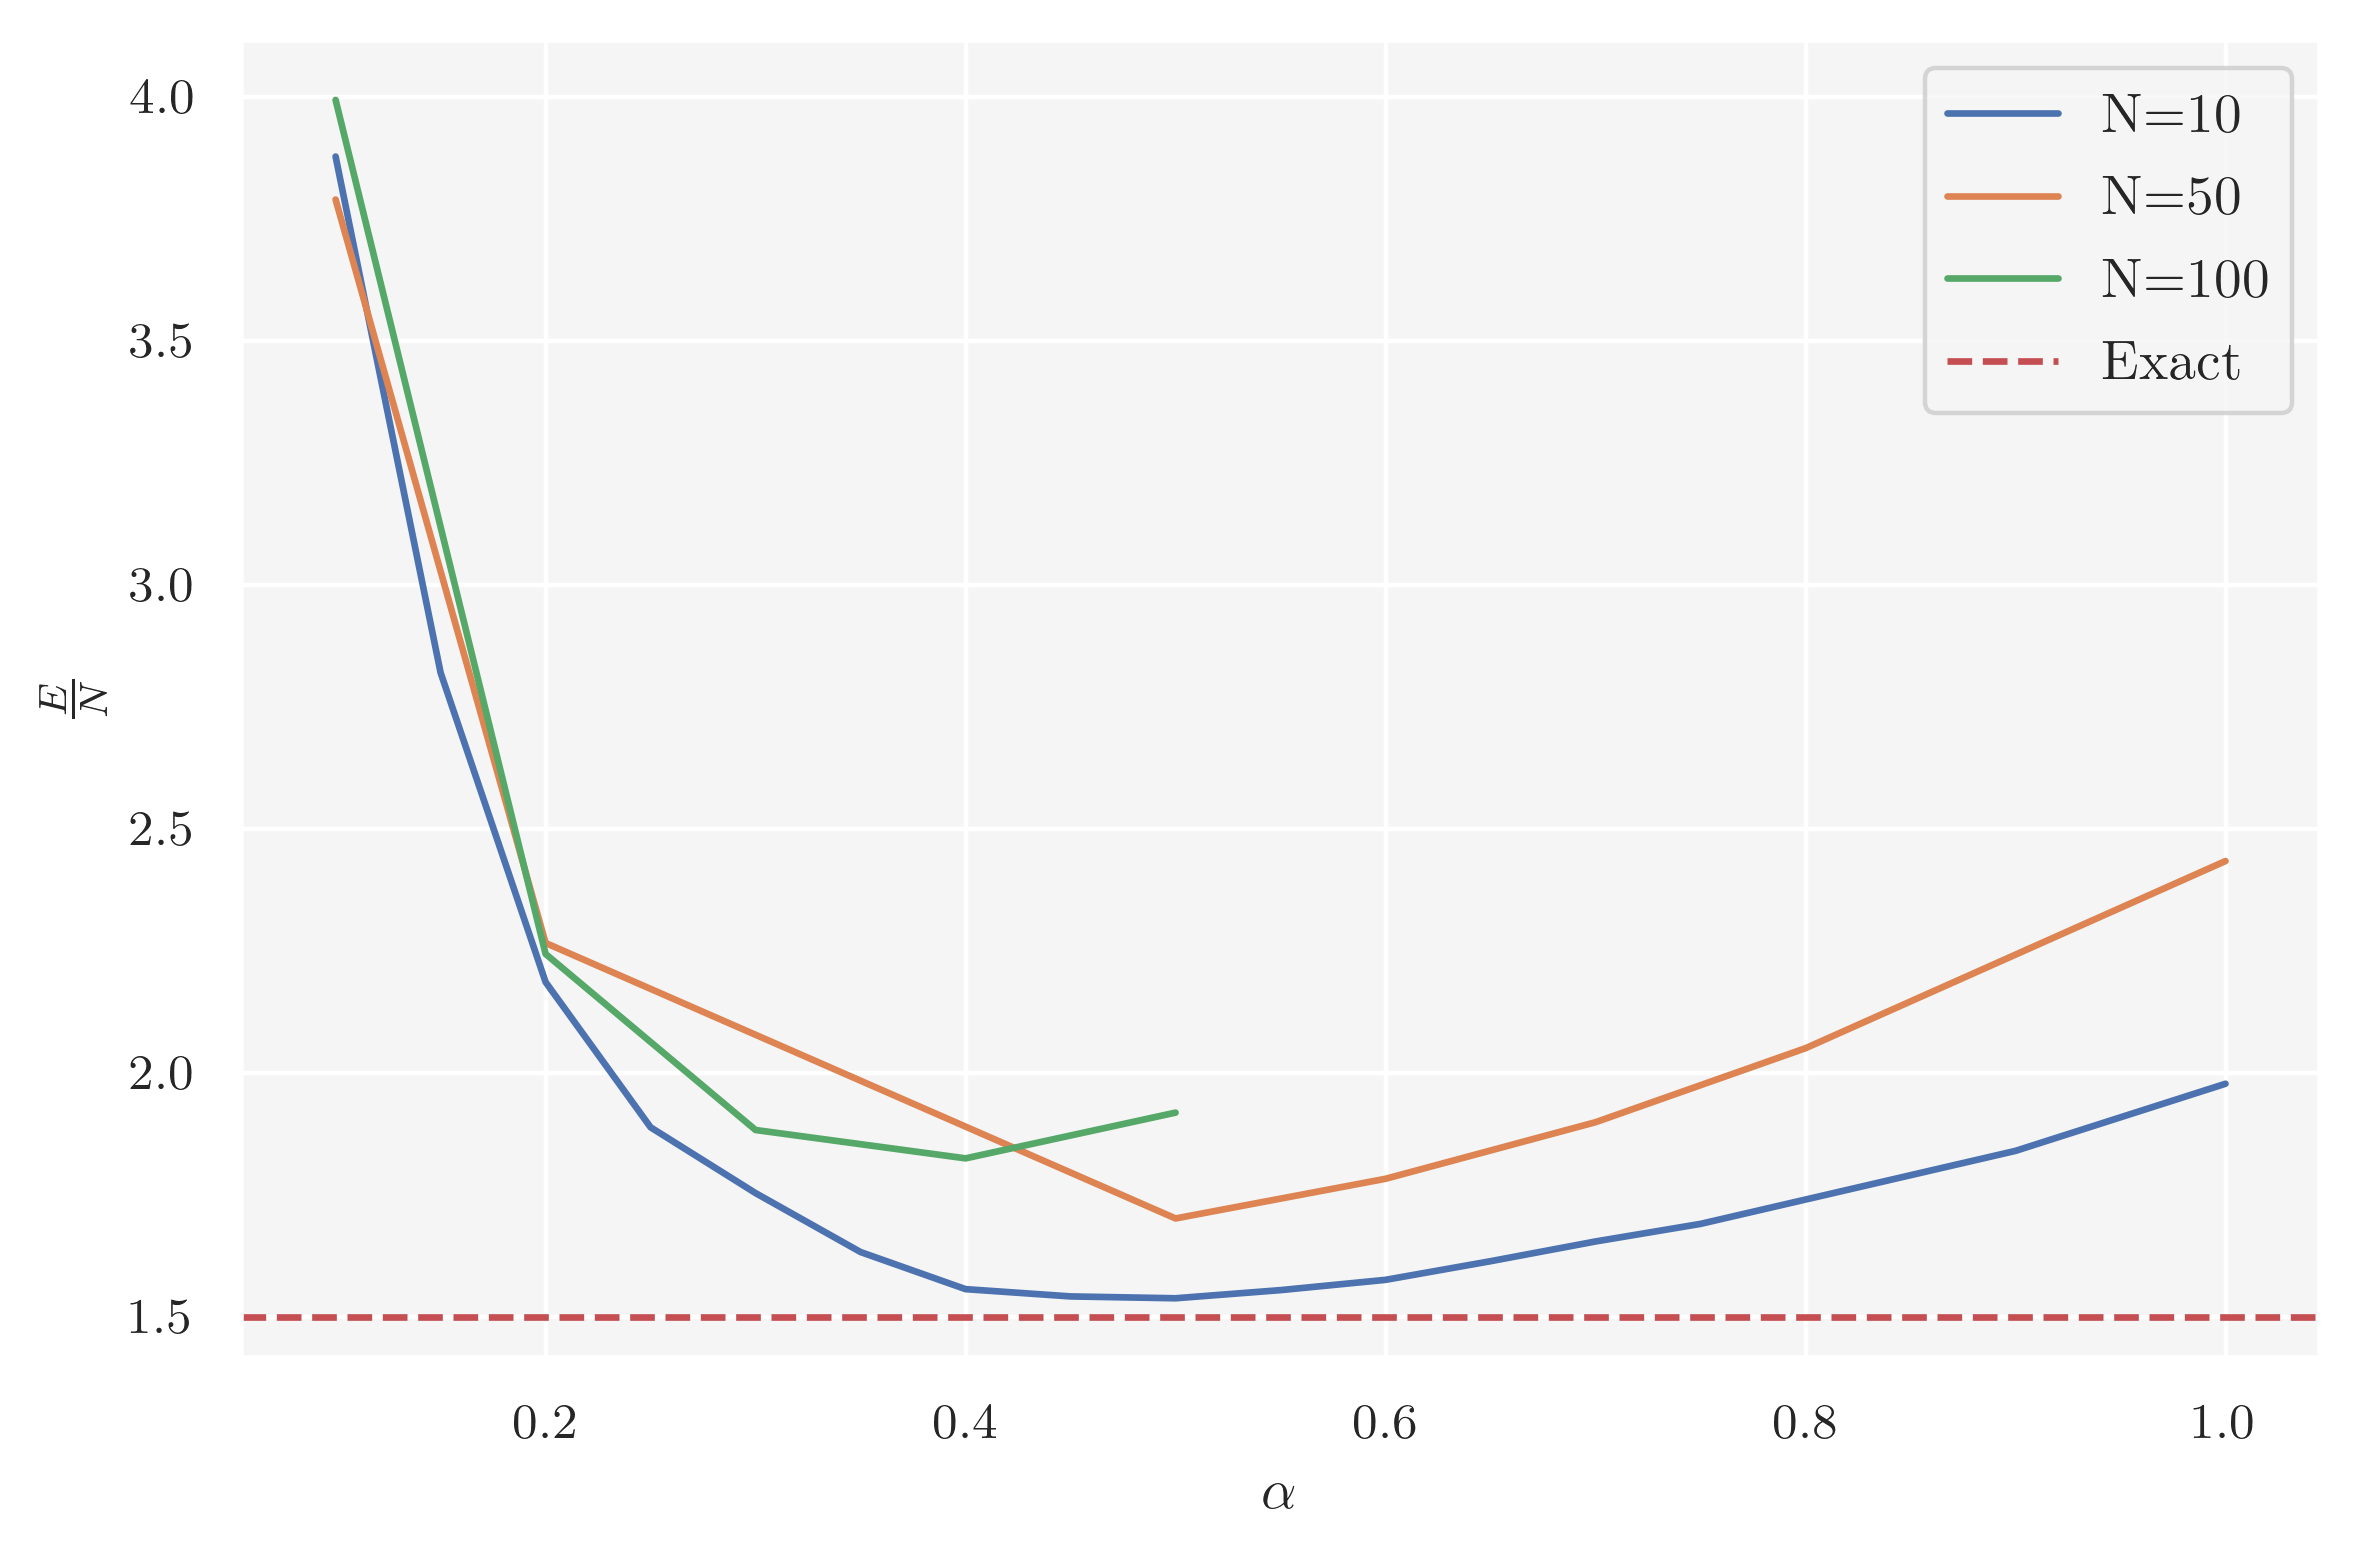

In [21]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_10, x="alpha", y="energy", ax=ax, label="N=10")
sns.lineplot(data=mod_df_50, x="alpha", y="energy", ax=ax, label="N=50")
sns.lineplot(data=mod_df_100, x="alpha", y="energy", ax=ax, label="N=100")
ax.axhline(NI_exact_energy_100/100.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_all_N.pdf"), bbox_inches='tight')